# Denoising Autoencoders for Time series data

In [90]:
%matplotlib inline

In [91]:
import numpy as np
from os import listdir
import pandas as pd
import datetime
from pytz import timezone
from scipy import signal
import matplotlib.pyplot as plt

In [92]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# use only half of available GPU RAM
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

Let's define a few utility functions to split time series into rolling windows:

Let's set the window size for the time serie processing.

In [93]:
window_size = 1800

In [273]:
# https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator
from itertools import islice

def window_all(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
        
"""
def windowize(seq, w_size=window_size):
    dd = list()
    for w in window_all(seq, w_size):
        dd += [np.array(w)]
    dd = np.array(dd)
    return dd
"""
def windowize(seq, w_size=window_size):
    return np.array(list(window_all(seq, w_size)))

def expand_windowize(seq, batch_size=None, w_size=window_size):
    return np.expand_dims( windowize(seq, w_size), axis=2 )

from itertools import izip
def windowize_generators(seq_x, seq_y, batch_size, w_size=window_size):
    """
        Return a generator from the 2 individual generators
    """
    for x, y in izip(expand_windowize(seq_x, batch_size, w_size),
                     expand_windowize(seq_y, batch_size, w_size)
                    ):
        yield x, y
        

def batch_generator(seq_x, seq_y, batch_size, w_size=window_size, debug=False):
    # Create empty arrays to contain batch of features and labels
    batch_x = np.zeros((batch_size, w_size))
    batch_y = np.zeros((batch_size, w_size))

    loop = True
    while loop:
        for i in range(batch_size):
            # choose random window_size window from sequences
            index = np.random.randint(low=0, high=len(seq_x)-w_size, size=1)
            batch_x[i] = seq_x[ index[0]:index[0]+w_size ]
            batch_y[i] = seq_y[ index[0]:index[0]+w_size ]
        if debug: loop = False
        yield np.expand_dims(batch_x, axis=2), np.expand_dims(batch_y, axis=2)

## Denoising gaussian noise

Creating a periodic input signal of size 6*window_size

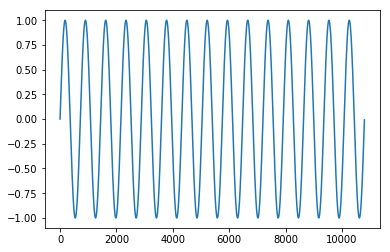

In [96]:
amplitude = 1.0
sequence_length = window_size * 6
f = 15 # 5Hz
sampling_rate = 1

x = np.arange(sequence_length)
y = amplitude * np.sin(((2 * np.pi) * f * x) / (sampling_rate*sequence_length))

ts = pd.Series(y, index=x)
ts.plot()

Adding white noise to the signal amplitude:

Max noise 3.287787897172018


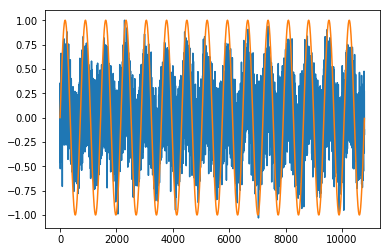

In [97]:
seed = 1234
np.random.seed(seed)
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html
noise = np.random.normal(0, 1, len(x))
print "Max noise", np.amax(noise)

y_noise = y + noise
y_noise = y_noise / np.amax(y_noise)

noisy_ts = pd.Series(y_noise, index=x)

noisy_ts.plot()
plt.subplot()
ts.plot()

Splitting both the noisy input signal and the raw output signal in 4 (80%) train and 2 (20%) test windows:

In [98]:
num_windows = len(x) / window_size
print "found", num_windows, "windows of", window_size, "samples each"

ceil = False
split_rate = 0.8

import math
train_windows = int(math.ceil(num_windows * split_rate) if ceil else math.floor(num_windows * split_rate))

print "train windows", train_windows
print "test windows", num_windows - train_windows

# split in train and test data
ts_train = ts.iloc[0:train_windows*window_size]
ts_test = ts.iloc[train_windows*window_size:]

print "len ts_train", ts_train.shape, "total train samples"
print "len ts_test", ts_test.shape, "total test samples"

noisy_ts_train = noisy_ts.iloc[0:train_windows*window_size]
noisy_ts_test = noisy_ts.iloc[train_windows*window_size:]

print "len noisy_ts_train", noisy_ts_train.shape
print "len noisy_ts_test", noisy_ts_test.shape

found 6 windows of 1800 samples
train windows 4
test windows 2
ts_train (7200,)
ts_test (3600,)
noisy_ts_train (7200,)
noisy_ts_test (3600,)


Using windowize to roll over the signals a window of size window_size for the whole lenght of the time series, since the example dataset fits in RAM and would be too small otherwise:

In [99]:
x_ts_train = windowize(noisy_ts_train, w_size=window_size)
print x_ts_train.shape

x_ts_test = windowize(noisy_ts_test, w_size=window_size)
print x_ts_test.shape

y_ts_train = windowize(ts_train, w_size=window_size)
print y_ts_train.shape

y_ts_test = windowize(ts_test, w_size=window_size)
print y_ts_test.shape

(5401, 1800)
(1801, 1800)
(5401, 1800)
(1801, 1800)


This way we generate 1+3*(window_size) = 5401 windows, each with 1800 power samples, and similarly for test we have 1 window of size 1800 shifted 1800 times, i.e. 1801 windows of size 1800.
We then add another dimension to the data, as we need to indicate the number of features (i.e., 1) and have entries of size (n, window_size, 1).

In [100]:
x_ts_train = np.expand_dims(x_ts_train, axis=2)
print x_ts_train.shape

x_ts_test = np.expand_dims(x_ts_test, axis=2)
print x_ts_test.shape

y_ts_train = np.expand_dims(y_ts_train, axis=2)
print y_ts_train.shape

y_ts_test = np.expand_dims(y_ts_test, axis=2)
print y_ts_test.shape

(5401, 1800, 1)
(1801, 1800, 1)
(5401, 1800, 1)
(1801, 1800, 1)


This can be done also in case we desire to use a generator instead of loading everything in RAM:

In [192]:
print windowize_generator(noisy_ts_train, window_size).shape
print windowize_generator(ts_train, window_size).shape

batch_size = 15
print np.array(list( 
            #windowize_generators(noisy_ts_train, ts_train, window_size) 
            batch_generator(noisy_ts_train, ts_train, batch_size, window_size, debug=True)
        )).shape

(5401, 1800, 1)
(5401, 1800, 1)
(1, 2, 15, 1800, 1)


A windowize_generator is defined as generator function to return for each batch size a window of size window_size.
Similarly, we define a windowize_generators as a generator able to return a batch size of windows of size window_size from the input noisy signal and the output raw signal.

In [ ]:
for i in windowize_generators(noisy_ts_train, ts_train, window_size):
    print np.array(i).shape
    break

### Denoising autoencoder with dense layers

In [102]:
from keras import Input, metrics
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D, K
from keras.optimizers import Adadelta, SGD

In [103]:
#dense_autoencoder = Sequential(name="Dense_DenoisingAutoencoder")

# todo

### Denoising autoencoder using convolution layers

In [204]:
use_windowize = False

In [241]:
convolution_autoencoder = Sequential(name="CNN_DenoisingAutoencoder")

# encoder
# https://keras.io/layers/convolutional/#conv1d
# stage 1: 
# window_size x 64
print "input shape is", (window_size, 1)

convolution_autoencoder.add(Conv1D(input_shape=(window_size, 1),
                           filters=64, # dimension of the output space
                           kernel_size=3, # length of the convolution window
                           padding="same",
                           activation="relu"
                          ) 
                   )
   
# (window_size/2) x 64
convolution_autoencoder.add(MaxPooling1D(pool_size=2, padding="same"))
# stage 2: 
# (window_size/2) x 128
convolution_autoencoder.add(Conv1D(filters=128,
                                   kernel_size=3,
                                   padding='same',
                                   activation='relu'))
# (window_size/4) x 128
convolution_autoencoder.add(MaxPooling1D(pool_size=2, padding='same'))

# decoder
# stage 3:
# (window_size/4) x 128
convolution_autoencoder.add(Conv1D(filters=128,
                                   kernel_size=3,
                                   padding='same',
                                   activation='relu'))
# (window_size/2) x 128                
convolution_autoencoder.add(UpSampling1D(size=2))

# stage 4: 
# (window_size/2) x 64
convolution_autoencoder.add(Conv1D(filters=64,
                                   kernel_size=3,
                                   padding='same',
                                   activation='relu'))
# window_size x 64
convolution_autoencoder.add(UpSampling1D(size=2))                

# window_size x 1
convolution_autoencoder.add(Conv1D(filters=1,
                                   kernel_size=3,
                                   padding='same',
                                   #activation='sigmoid'
                                   activation='tanh'
                                  )
                           )

convolution_autoencoder.compile(optimizer='adam', loss='mean_squared_error')
print(convolution_autoencoder.summary())

input shape is (1800, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 1800, 64)          256       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 900, 64)           0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 900, 128)          24704     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 450, 128)          0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 450, 128)          49280     
_________________________________________________________________
up_sampling1d_23 (UpSampling (None, 900, 128)          0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 900, 64)       

In [242]:
seed = 1234
np.random.seed(seed)

In [248]:
epochs=5
batch_size=20 # num of samples for gradient update

# steps_per_epoch should typically be equal to the number of samples of your dataset divided by the batch size.
# Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.
steps_per_epoch = window_size / batch_size

if use_windowize:
    convolution_autoencoder.fit(x=x_ts_train,
                                y=y_ts_train,
                                validation_data=(x_ts_test, y_ts_test),
                                shuffle=True,
                                epochs=epochs,
                                batch_size=batch_size)
else:
    convolution_autoencoder.fit_generator(
        batch_generator(noisy_ts_train, ts_train, batch_size, window_size),
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        nb_epoch=epochs
    )

Epoch 1/5
 3/90 [>.............................] - ETA: 3s - loss: 0.0540

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=5, steps_per_epoch=90, verbose=1)`


90/90 [==============================] - 4s 47ms/step - loss: 0.0139
Epoch 2/5
90/90 [==============================] - 4s 45ms/step - loss: 0.0360
Epoch 3/5
90/90 [==============================] - 4s 46ms/step - loss: 0.0249
Epoch 4/5
90/90 [==============================] - 4s 46ms/step - loss: 0.0113
Epoch 5/5
90/90 [==============================] - 4s 47ms/step - loss: 0.0359


x.shape (20, 1800, 1)
y.shape (20, 1800, 1)


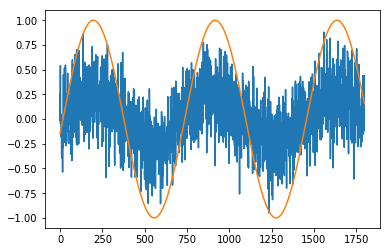

In [244]:
if use_windowize:
    print x_ts_train.shape
    print len(x_ts_train[0])
    print len(y_ts_train[0])
    plt.plot(range(window_size), x_ts_train[0])
    plt.subplot()
    plt.plot(range(window_size), y_ts_train[0])
else:
    np.random.seed(seed)
    bg = batch_generator(noisy_ts_train, ts_train, batch_size, window_size)
    x,y = bg.next()
    print "x.shape", x.shape
    print "y.shape", y.shape
    plt.plot(range(window_size), x[0])
    plt.subplot()
    plt.plot(range(window_size), y[0])

[[[-0.05404916]
  [-0.20870744]
  [-0.18544675]
  ...
  [ 0.23737477]
  [ 0.21777807]
  [ 0.18588394]]]
[[[-0.05404916]
  [-0.20870744]
  [-0.18544675]
  ...
  [ 0.23737477]
  [ 0.21777807]
  [ 0.18588394]]]
[-0.05404916 -0.20870744 -0.18544675 ...  0.23737477  0.21777807
  0.18588394]


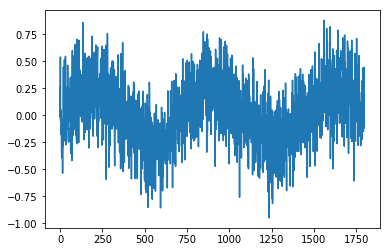

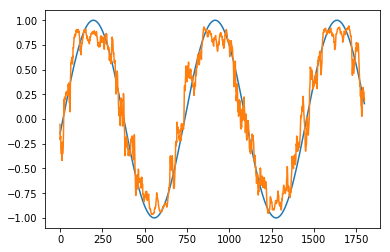

In [246]:
if use_windowize:
    # example prediction on the noisy input signal
    decoded = convolution_autoencoder.predict(
        np.reshape(x_ts_train[0], (1, window_size, 1))
    )
    print decoded * amplitude
    decoded.shape
    dec_y = np.reshape(decoded, window_size)
    print decoded
    print dec_y
    plt.plot(x_ts_train[0])
    plt.figure()
    plt.plot(y_ts_train[0])
    plt.plot(dec_y)
else:
    decoded = convolution_autoencoder.predict(
        np.reshape(x[0], (1, window_size, 1))
    )
    print decoded * amplitude
    decoded.shape
    dec_y = np.reshape(decoded, window_size)
    print decoded
    print dec_y
    plt.plot(x[0])
    plt.figure()
    plt.plot(y[0])
    plt.plot(dec_y)

## Load disaggreation as denoising problem

In this notebook we explore active power time series from the open GREEND dataset, which is freely available for download at https://sourceforge.net/projects/greend/. Moreover, we preprocess the dataset using the sample code from https://github.com/pilillo/needle-load-detector. Similar studies were carried out in https://www.researchgate.net/profile/Roberto_Bonfigli/publication/321287989_Denoising_Autoencoders_for_Non-Intrusive_Load_Monitoring_Improvements_and_Comparative_Evaluation/links/5a2e63d445851552ae7f1fff/Denoising-Autoencoders-for-Non-Intrusive-Load-Monitoring-Improvements-and-Comparative-Evaluation.pdf and compared to state-based approaches, i.e. variants of hidden-markov models.

In [251]:
from load_disaggregator import *

# building 1    
devices = ['000D6F00036BB04C', '000D6F00029C2BD7', '000D6F000353AC8C', 
           '000D6F0003562E10', '000D6F0003562C48', '000D6F00029C2984', 
           '000D6F000353AE51', '000D6F0003562C0F', '000D6F0003562BF6']

dataset_folder = "data/GREEND_0-2_300615/"

processor = DatasetProcessor(dataset_folder)        
df = processor.get_dataframe(building=1, days_no=4)

Plot the initial raw data from the GREEND.

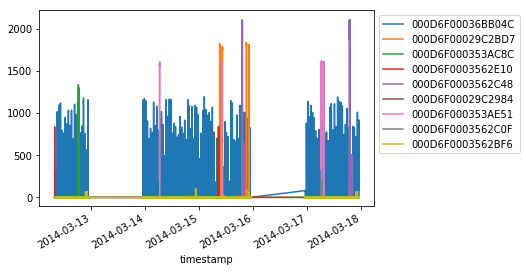

In [252]:
ax = df.plot(legend=False)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

#### Preprocessing the power time series

Remove NaN values using both pad and bfill together.

In [253]:
# preprocess the dataset
preprocessed = processor.remove_holes() # fill with pad and bfill
preprocessed.head()

,000D6F00036BB04C,000D6F00029C2BD7,000D6F000353AC8C,000D6F0003562E10,000D6F0003562C48,000D6F00029C2984,000D6F000353AE51,000D6F0003562C0F,000D6F0003562BF6
timestamp,,,,,,,,,
2014-03-12 07:52:42.470790,2.274737,0.0,2.171969,0.0,0.0,16.978532,0.0,0.0,0.0
2014-03-12 07:52:43.166152,0.000000,0.0,0.000000,0.0,0.0,19.085350,0.0,0.0,0.0
2014-03-12 07:52:44.153153,2.274737,0.0,2.171969,0.0,0.0,16.978532,0.0,0.0,0.0
2014-03-12 07:52:45.183690,0.000000,0.0,0.000000,0.0,0.0,16.978532,0.0,0.0,0.0
2014-03-12 07:52:46.503409,0.000000,0.0,0.000000,0.0,0.0,16.978532,0.0,0.0,0.0


Make sure the period of the data is uniform to 1 Hz (i.e. 1 second).

In [254]:
# makes sure the signal is at 1Hz
preprocessed = processor.uniform_period()
preprocessed.head()

,000D6F00036BB04C,000D6F00029C2BD7,000D6F000353AC8C,000D6F0003562E10,000D6F0003562C48,000D6F00029C2984,000D6F000353AE51,000D6F0003562C0F,000D6F0003562BF6
timestamp,,,,,,,,,
2014-03-12 07:52:42,2.274737,0.0,2.171969,0.0,0.0,16.978532,0.0,0.0,0.0
2014-03-12 07:52:43,0.000000,0.0,0.000000,0.0,0.0,19.085350,0.0,0.0,0.0
2014-03-12 07:52:44,2.274737,0.0,2.171969,0.0,0.0,16.978532,0.0,0.0,0.0
2014-03-12 07:52:45,0.000000,0.0,0.000000,0.0,0.0,16.978532,0.0,0.0,0.0
2014-03-12 07:52:46,0.000000,0.0,0.000000,0.0,0.0,16.978532,0.0,0.0,0.0


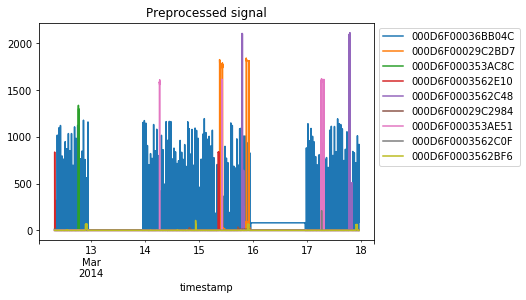

In [255]:
ax = preprocessed.plot(title="Preprocessed signal", legend=False)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

Plot the aggregated signal and the individual devices.

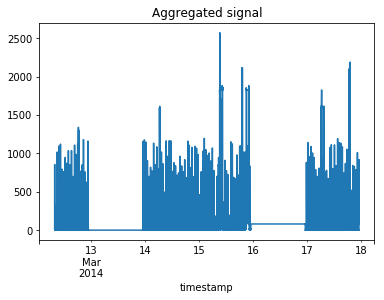

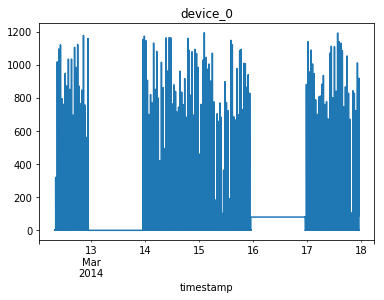

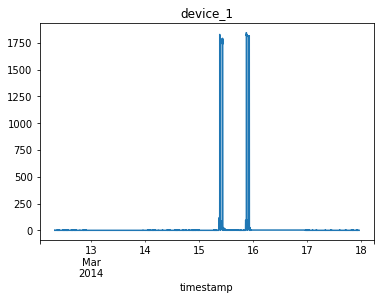

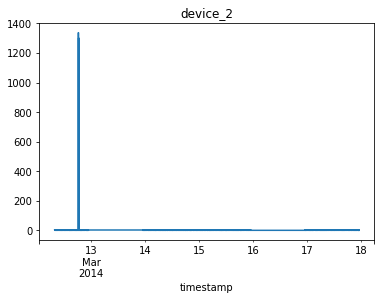

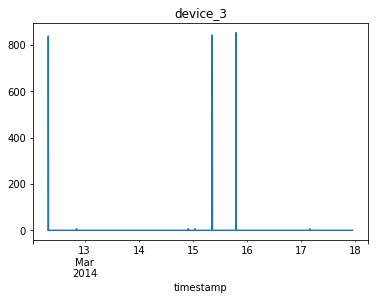

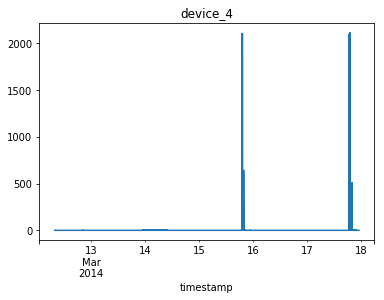

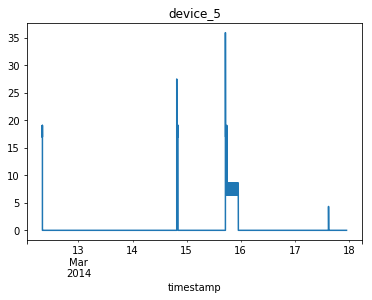

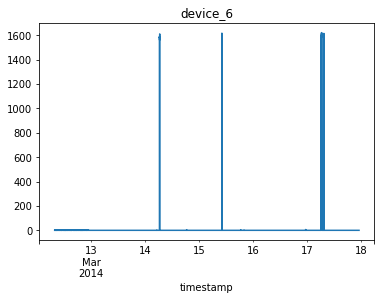

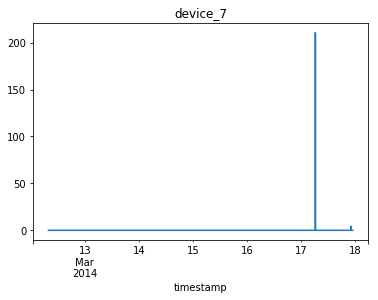

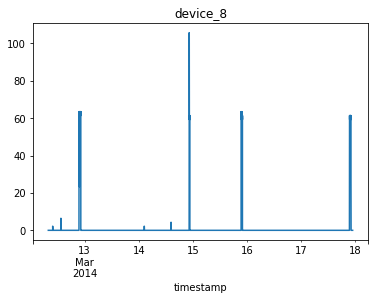

In [256]:
processor.get_aggregated_signal().plot(title="Aggregated signal")

for i, t in enumerate(devices):
    if t is not None and len(t)>0:
        plt.figure()
        processor.get_disaggregated_signal(devices[i]).plot(title="device_"+str(i))

#### Extracting device signatures

Extract a signature for each device.

In [257]:
template_folder="" # save to local folder

In [258]:
extract = False
if extract:
    # Extract signatures for individual devices
    processor.get_datastore(template_folder+"dev_signatures.h5")

    # Device 0 (fridge)
    signature0 = processor.select_datetime_interval('2014-03-12 08:18:40', '2014-03-12 08:29:00')[devices[0]]
    processor.add_signature('devices/d0', signature0)

    #Device 1 (dishwasher)
    signature1 = processor.select_datetime_interval('2014-03-13 10:28:30',  '2014-03-13 11:45:00')[devices[1]]
    processor.add_signature('devices/d1', signature1)

    # Device 2 (microwave)
    signature2 = processor.select_datetime_interval('2014-03-12 18:24:40',  '2014-03-12 18:26:20')[devices[2]]
    processor.add_signature('devices/d2', signature2)

    # Device 3 water kettle
    signature3 = processor.select_datetime_interval('2014-03-15 08:32:00', '2014-03-15 08:42:20')[devices[3]]
    processor.add_signature('devices/d3', signature3)

    # Device 4
    signature4 = processor.select_datetime_interval('2014-03-13 18:32:00', '2014-03-13 19:58:30')[devices[4]]    # on the second day (that is why we use datetime)
    processor.add_signature('devices/d4', signature4)

    # Device 5 (amplifier)
    #signature = processor.select_time_interval('18:24:40', '18:26:20')[devices[5]]
    #signature5 = processor.select_datetime_interval('2014-03-12 18:24:40', '2014-03-12 18:26:20')[devices[5]]

    # Device 6 (hair dryer + charger )
    signature6 = processor.select_datetime_interval('2014-03-15 10:03:45', '2014-03-15 10:06:30')[devices[6]]
    processor.add_signature('devices/d6', signature6)

    # Device 7 (food processor) --> neverused

    # Device 8 Bedside lamp
    signature8 = processor.select_datetime_interval('2014-03-13 22:27:45', '2014-03-13 22:37:40')[devices[8]]
    processor.add_signature('devices/d8', signature8)

    processor.close_datastore()

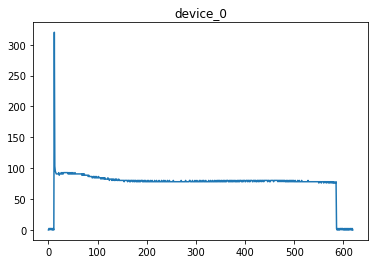

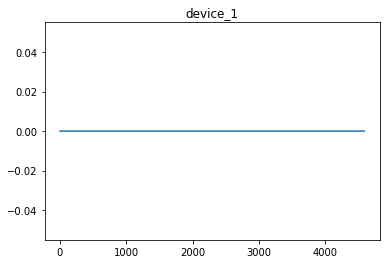

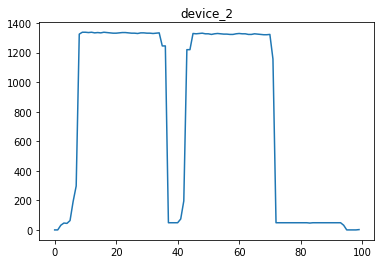

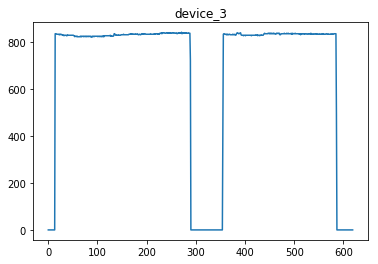

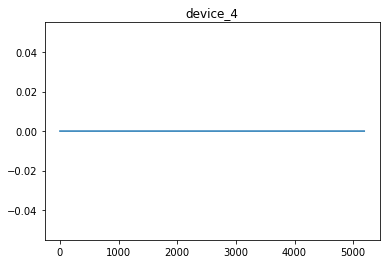

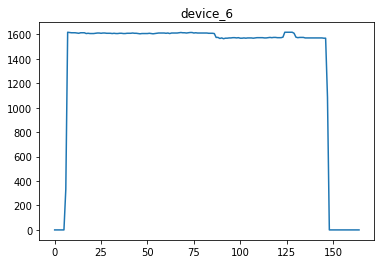

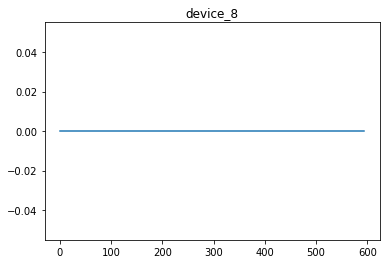

In [259]:
processor.get_datastore(template_folder+"dev_signatures.h5")

templates = [processor.get_signature('devices/d0'),
             processor.get_signature('devices/d1'),
             processor.get_signature('devices/d2'),
             processor.get_signature('devices/d3'),
             processor.get_signature('devices/d4'),
             None, 
             processor.get_signature('devices/d6'),
             None,
             processor.get_signature('devices/d8') ]

for i, t in enumerate(templates):
    if t is not None and (not t.empty):
        plt.figure()
        t.plot(title="device_"+str(i))

#### Normalizing the dataset

In [260]:
dev_id = 0

x = processor.get_aggregated_signal()
y = processor.get_disaggregated_signal(devices[i])

print x.shape
print y.shape

(486308,)
(486308,)


In [261]:
# find the peak power for each device from the extracted templates
max_t = []
for i, t in enumerate(templates):
    if t is not None and (not t.empty):
        max_t.append( np.amax(t) )
    else:
        max_t.append( 0 )
print max_t
# this is the peak power we shall expect as input
max_x = sum(max_t)
print max_x
# Problem 1: for different houses we would have completely different models
# to generalize a house we should use typical device categories
# for the ouput we can use the max_t of the specific device we want to model

[320.2258102791834, 0.0, 1337.9992326344902, 841.9707410934543, 0.0, 0, 1617.6053480771338, 0, 0.0]
4117.801132084262


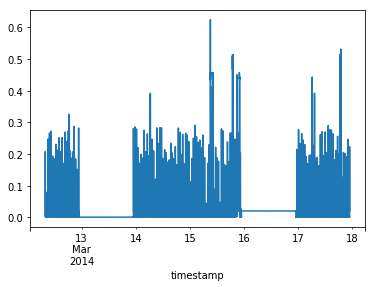

In [262]:
normalized_x = x / max_x
normalized_x.plot()

Normalizing based on device  0 whose peak power is  320.2258102791834


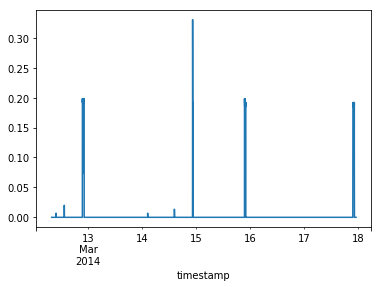

In [263]:
print "Normalizing based on device ", dev_id, "whose peak power is ", max_t[dev_id]
normalized_y = y / max_t[dev_id]
normalized_y.plot()

#### Splitting in train and test datasets

In [264]:
# split in train and test data based on a specific date time
split_datetime = "2014-03-15 00:00:00"

x_train = normalized_x[normalized_x.index < split_datetime]
y_train = normalized_y[normalized_y.index < split_datetime]

print x_train.shape
print y_train.shape

x_test = normalized_x[normalized_x.index >= split_datetime]
y_test = normalized_y[normalized_y.index >= split_datetime]

print x_test.shape
print y_test.shape

(230838,)
(230838,)
(255470,)
(255470,)


#### Create windows of nilm_window_size that can be used to train the autoencoder

In [265]:
# set the size of the detector to the device template
nilm_window_size = len(templates[dev_id])
print nilm_window_size
# since 4590 is difficult to divide by 2 and leads to asymmetries 4590/2/2=1147.5 (which is rounded to 1148)
# let's increase it to 4600. 4600/2/2 = 1150.
nilm_window_size=4600
print nilm_window_size

620
4600


In [266]:
use_windowize = False

In [267]:
if use_windowize:
    # def windowize(seq, w_size=window_size)
    x_train_ = windowize(x_train, nilm_window_size)
    print x_train_.shape
    x_test_ = windowize(x_test, nilm_window_size)
    print x_test_.shape
    y_train_ = windowize(y_train, nilm_window_size)
    print y_train_.shape
    y_test_ = windowize(y_test, nilm_window_size)
    print x_test_.shape

In [268]:
if use_windowize:
    x_train__ = np.expand_dims(x_train_, axis=2)
    print x_train__.shape
    x_test__ = np.expand_dims(x_test_, axis=2)
    print x_test__.shape
    y_train__ = np.expand_dims(y_train_, axis=2)
    print y_train__.shape
    y_test__ = np.expand_dims(y_test_, axis=2)
    print x_test__.shape

#### Define a CNN-autoencoder to denoise the signal

In [269]:
from keras import Input, metrics
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D, K
from keras.optimizers import Adadelta, SGD

print "Using input window of size", nilm_window_size

nilm_autoencoder = Sequential(name="DenoisingAutoencoder")

# encoder
# https://keras.io/layers/convolutional/#conv1d
# stage 1: 
# nilm_window_size x 64
nilm_autoencoder.add(Conv1D(input_shape=(nilm_window_size, 1),
                            filters=64, # dimension of the output space
                            kernel_size=3, # length of the convolution window
                            padding="same",
                            activation="relu"
                           ) 
                    )
# (nilm_window_size/2) x 64
nilm_autoencoder.add(MaxPooling1D(pool_size=2, padding="same"))
# stage 2: 
# (nilm_window_size/2) x 128
nilm_autoencoder.add(Conv1D(filters=128,
                       kernel_size=3,
                       padding='same',
                       activation='relu'
                      )
               )
# (nilm_window_size/4) x 128
nilm_autoencoder.add(MaxPooling1D(pool_size=2, padding='same'))

# decoder
# stage 3:
# (nilm_window_size/4) x 128
nilm_autoencoder.add(Conv1D(filters=128,
                            kernel_size=3,
                            padding='same',
                            activation='relu'))
# (nilm_window_size/2) x 128                
nilm_autoencoder.add(UpSampling1D(size=2))

# stage 4: 
# (nilm_window_size/2) x 64
nilm_autoencoder.add(Conv1D(filters=64,
                            kernel_size=3,
                            padding='same',
                            activation='relu'))
# nilm_window_size x 64
nilm_autoencoder.add(UpSampling1D(size=2))                

# nilm_window_sizes x 1
nilm_autoencoder.add(Conv1D(filters=1,
                            kernel_size=3,
                            padding='same',
                            activation='sigmoid'))

nilm_autoencoder.compile(loss='mse', optimizer='adam')
print(nilm_autoencoder.summary())

Using input window of size 4600
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 4600, 64)          256       
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 2300, 64)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 2300, 128)         24704     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 1150, 128)         0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 1150, 128)         49280     
_________________________________________________________________
up_sampling1d_25 (UpSampling (None, 2300, 128)         0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 2300, 64

In [279]:
epochs=10
#epochs=60
batch_size=25
seed = 1234

steps_per_epoch = nilm_window_size / batch_size

np.random.seed(seed)
if use_windowize:
    nilm_autoencoder.fit(x=x_train__,
                         y=y_train__,
                         validation_data=(x_test__, y_test__),
                         shuffle=True,
                         epochs=epochs,
                         batch_size=batch_size)
else:
    nilm_autoencoder.fit_generator(
        #windowize_generators(x_train, y_train, batch_size), samples_per_epoch=50, nb_epoch=epochs
        batch_generator(x_train, y_train, batch_size, nilm_window_size, debug=False),
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        nb_epoch=epochs
    )

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=10, steps_per_epoch=184, verbose=1)`


Epoch 1/10
184/184 [==============================] - 19s 103ms/step - loss: 6.6684e-04
Epoch 2/10
184/184 [==============================] - 18s 98ms/step - loss: 7.2154e-04
Epoch 3/10
184/184 [==============================] - 19s 101ms/step - loss: 7.9825e-04
Epoch 4/10
184/184 [==============================] - 19s 104ms/step - loss: 8.0584e-04
Epoch 5/10
184/184 [==============================] - 18s 100ms/step - loss: 6.9731e-04
Epoch 6/10
184/184 [==============================] - 18s 98ms/step - loss: 7.2105e-04
Epoch 7/10
184/184 [==============================] - 18s 99ms/step - loss: 6.3335e-04
Epoch 8/10
184/184 [==============================] - 19s 101ms/step - loss: 6.8194e-04
Epoch 9/10
184/184 [==============================] - 18s 100ms/step - loss: 7.1339e-04
Epoch 10/10
184/184 [==============================] - 18s 98ms/step - loss: 7.4540e-04


x.shape (25, 4600, 1)
y.shape (25, 4600, 1)


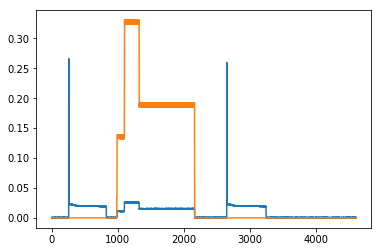

In [280]:
if use_windowize:
    print len(x_train__[0])
    print len(y_train__[0])
    plt.plot(range(len(x_train__[0])), x_train__[0])
    plt.subplot()
    plt.plot(range(len(y_train__[0])), y_train__[0])
else:
    np.random.seed(seed)
    bg = batch_generator(x_train, y_train, batch_size, nilm_window_size, debug=False)
    x,y = bg.next()
    print "x.shape", x.shape
    print "y.shape", y.shape
    plt.plot(range(nilm_window_size), x[0])
    plt.subplot()
    plt.plot(range(nilm_window_size), y[0])

[[[1.9961095e-03]
  [2.1604608e-05]
  [2.2852307e-06]
  ...
  [4.1844964e-06]
  [3.6137109e-05]
  [3.8725587e-03]]]
[[[1.9961095e-03]
  [2.1604608e-05]
  [2.2852307e-06]
  ...
  [4.1844964e-06]
  [3.6137109e-05]
  [3.8725587e-03]]]
[1.9961095e-03 2.1604608e-05 2.2852307e-06 ... 4.1844964e-06 3.6137109e-05
 3.8725587e-03]


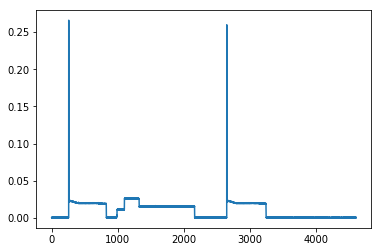

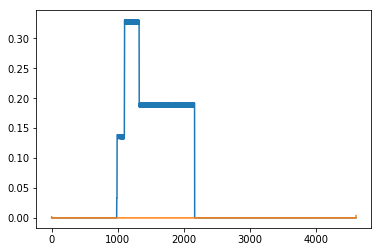

In [278]:
if use_windowize:
    # example prediction on the noisy input signal
    decoded = nilm_autoencoder.predict(
        np.reshape(x_train__[0], (1, nilm_window_size, 1))
    )

    # scale up to the max power registered for the device
    print decoded * max_t[dev_id]
    decoded.shape

    dec_y = np.reshape(decoded, nilm_window_size)

    plt.plot(x_train__[0])
    plt.figure()
    plt.plot(y_train__[0])
    plt.plot(dec_y)
else:
    decoded = nilm_autoencoder.predict(
        np.reshape(x[0], (1, nilm_window_size, 1))
    )
    print decoded * amplitude
    decoded.shape
    dec_y = np.reshape(decoded, nilm_window_size)
    print decoded
    print dec_y
    plt.plot(x[0])
    plt.figure()
    plt.plot(y[0])
    plt.plot(dec_y)

This is just an example. The way we trained this model is totally stupid, since the generator does not consider that the device being OFF occurs way more often than it being ON. To care of this, we need to build a data structure where we can further distinguish in windows where the device has been used, and make sure their number is related to that of the windows where the device is OFF.

In [277]:
if use_windowize:
    for i, y_ts in enumerate(y_train__):
        if np.count_nonzero(y_ts) > 2948:
            # example prediction on the noisy input signal
            decoded = nilm_autoencoder.predict(np.reshape(x_train__[i], (1, nilm_window_size, 1)))
            dec_y = np.reshape(decoded, nilm_window_size)
            # scale up to the max power registered for the device
            decoded_s = decoded * max_t[dev_id]
            dec_y_s = np.reshape(decoded, nilm_window_size)

            plt.title('Ground Truth')
            agg_ts, = plt.plot(x_train__[i])
            a_dev_ts, = plt.plot(y_train__[i])
            plt.legend([agg_ts, a_dev_ts], ["Aggregated Signal", "Device Signal"])
            x1,x2,y1,y2 = plt.axis()
            plt.axis((x1,x2,0.0,1.0))

            plt.figure()
            plt.title('Output')
            dis_ts, = plt.plot(dec_y)
            dev_ts, = plt.plot(y_train__[i])
            dis_s_ts, = plt.plot(dec_y_s)
            plt.legend([dis_ts, dev_ts, dis_s_ts], ["Disaggregated Signal", "Device Signal", "Scaled Disaggregated Signal"])
            x1,x2,y1,y2 = plt.axis()
            plt.axis((x1,x2,0.0,1.0))
            break

In [ ]:
print len( y_train__)

cc = [ (i, np.count_nonzero(y_train__[i])) for i, k in enumerate(y_train__) if np.count_nonzero(y_train__[i]) > 1000 ]

In [ ]:
max([c[1] for c in cc])